In [1]:
import xarray as xr
import glob
import intake
import numpy as np

# import warnings
# warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
from plotting_maps.acs_plotting_maps import plot_acs_hazard_multi, plot_acs_hazard, plot_data, cmap_dict, regions_dict
from matplotlib import colors, cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from dask.diagnostics import ProgressBar
# ProgressBar().register()

import dask
from dask.distributed import Client
client = Client(threads_per_worker=2, n_workers=8)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40975 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:46497' processes=8 threads=16, memory=125.19 GiB>

In [3]:
cat_name = "barpa"
col = intake.open_esm_datastore(f"/g/data/lp01/collections/py3.9_dev/nci-{cat_name}.json")
col.unique()

activity_id                                                    [BARPA-R]
institution_id                                                     [BOM]
version                [v20231001, v20240501, v20240401, v20240601, v...
variable_id            [CAPE, CIN, clh, clivi, cll, clm, clt, clwvi, ...
table_id                                        [1hr, 6hr, day, fx, mon]
source_id              [ACCESS-CM2, ACCESS-ESM1-5, CESM2, CMCC-ESM2, ...
experiment_id           [historical, ssp126, ssp370, ssp585, evaluation]
member_id                      [r4i1p1f1, r6i1p1f1, r11i1p1f1, r1i1p1f1]
grid_label                                                      [AUS-15]
time_range             [196001-196012, 196101-196112, 196201-196212, ...
path                   [/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM...
derived_variable_id                                                   []
dtype: object

In [4]:
variable_paths = col.df.groupby("variable_id").max()["path"]
var_list = list(variable_paths.index)
variable_paths

variable_id
CAPE     /g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
CIN      /g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
clh      /g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
clivi    /g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
cll      /g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
                               ...                        
zg70     /g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
zg700    /g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
zg850    /g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
zg925    /g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
zmla     /g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
Name: path, Length: 192, dtype: object

In [5]:
variable_paths["orog"]

'/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/NorESM2-MM/ssp370/r1i1p1f1/BARPA-R/v1-r1/fx/orog/v20231001/orog_AUS-15_NorESM2-MM_ssp370_r1i1p1f1_BOM_BARPA-R_v1-r1_fx.nc'

In [6]:
standard_names = ['VAR, standard_name',]
for var, path in zip(var_list, variable_paths):
    name = xr.open_dataset(path)[var].standard_name
    standard_names.append(f"{var}, {name}")    
standard_names

['VAR, standard_name',
 'CAPE, atmosphere_convective_available_potential_energy_wrt_surface',
 'CIN, atmosphere_convective_inhibition_wrt_surface',
 'clh, cloud_area_fraction_in_atmosphere_layer',
 'clivi, atmosphere_mass_content_of_cloud_ice',
 'cll, cloud_area_fraction_in_atmosphere_layer',
 'clm, cloud_area_fraction_in_atmosphere_layer',
 'clt, cloud_area_fraction',
 'clwvi, atmosphere_mass_content_of_cloud_condensed_water',
 'evspsbl, water_evapotranspiration_flux',
 'evspsblpot, water_potential_evaporation_flux',
 'hfls, surface_upward_latent_heat_flux',
 'hfss, surface_upward_sensible_heat_flux',
 'hurs, relative_humidity',
 'hus10, specific_humidity',
 'hus100, specific_humidity',
 'hus1000, specific_humidity',
 'hus150, specific_humidity',
 'hus20, specific_humidity',
 'hus200, specific_humidity',
 'hus250, specific_humidity',
 'hus30, specific_humidity',
 'hus300, specific_humidity',
 'hus400, specific_humidity',
 'hus50, specific_humidity',
 'hus500, specific_humidity',
 'hus

In [7]:
# filelist = glob.glob("/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/historical/r4i1p1f1/BARPA-R/v1-r1/6hr/*/v20231001/*_AUS-15_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_6hr_196001-196012.nc")
# filelist.sort()
# filelist


In [8]:
var_list_sample = [
                   # 'hus10', 'hus20', 'hus30', 
                   'hus50', 'hus70', 'hus100', 'hus150', 'hus200', 'hus250', 'hus300', 'hus400',
                   # 'hus500', 'hus600', 'hus700', 'hus850', 'hus925', 'hus1000',
                   # 'ta10', 'ta20', 'ta30', 'ta50', 'ta70', 
                   'ta50', 'ta70', 'ta100', 'ta150', 'ta200', 'ta250', 'ta300', 'ta400', 
                   # 'ta500', 'ta600', 'ta700', 'ta850', 'ta925', 'ta1000', 
                   # 'ua10', 'ua20', 'ua30', 
                   'ua50', 'ua70', 'ua100', 'ua150', 'ua200', 'ua250', 'ua300', 'ua400',
                   # 'ua500', 'ua600', 'ua700', 'ua850', 'ua925', 'ua1000',
                   # 'va10', 'va20', 'va30', 
                   'va50', 'va70', 'va100', 'va150', 'va200', 'va250', 'va300', 'va400',
                   # 'va500', 'va600', 'va700', 'va850', 'va925', 'va1000',
                   # 'wa10', 'wa20', 'wa30',
                   'wa50', 'wa70', 'wa100', 'wa150', 'wa200', 'wa250', 'wa300', 'wa400',
                   # 'wa500', 'wa600', 'wa700', 'wa850', 'wa925', 'wa1000',
                   # 'zg10', 'zg20', 'zg30', 
                   'zg50', 'zg70', 'zg100', 'zg150', 'zg200', 'zg250', 'zg300', 'zg400', 
                   # 'zg500', 'zg600', 'zg700', 'zg850', 'zg925', 'zg1000',
                  ]
filelist_fx = ['/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/historical/r4i1p1f1/BARPA-R/v1-r1/fx/orog/v20231001/orog_AUS-15_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_fx.nc']
filelist_1hr = [f'/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/historical/r4i1p1f1/BARPA-R/v1-r1/1hr/{VAR}/v20231001/{VAR}_AUS-15_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_1hr_196001-196012.nc'
                for VAR in ['clivi', 'clwvi',]]
filelist = [f"/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/historical/r4i1p1f1/BARPA-R/v1-r1/6hr/{VAR}/v20231001/{VAR}_AUS-15_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_6hr_196001-196012.nc" 
for VAR in var_list_sample] 

In [9]:
%%time
ds = xr.open_mfdataset(filelist[:], 
                       combine="by_coords", 
                       compat="override",
                       use_cftime=True,
                       preprocess=lambda ds:ds.sel(time="1960-06-01").drop_vars(["crs", "pressure"]) )
#
ds_1hr = xr.open_mfdataset(filelist_1hr, preprocess=lambda ds:ds.drop_vars(["crs"]).sel(time="1960-06-01").resample(time='6h').mean(),) 
ds_fx = xr.open_mfdataset(filelist_fx, preprocess=lambda ds:ds.drop_vars(["crs"]), chunks={"lat":-1, "lon":-1})
ds = xr.merge([ds, ds_1hr, ds_fx])
ds

CPU times: user 1.67 s, sys: 415 ms, total: 2.08 s
Wall time: 2.34 s


<xarray.Dataset> Size: 543MB
Dimensions:  (time: 4, lon: 777, lat: 436)
Coordinates:
  * time     (time) object 32B 1960-06-01 00:00:00 ... 1960-06-01 18:00:00
  * lon      (lon) float64 6kB 88.04 88.19 88.34 88.5 ... 207.6 207.8 207.9
  * lat      (lat) float64 3kB -53.58 -53.42 -53.27 -53.11 ... 13.32 13.48 13.63
Data variables: (12/51)
    hus100   (time, lat, lon) float64 11MB dask.array<chunksize=(4, 66, 120), meta=np.ndarray>
    hus150   (time, lat, lon) float64 11MB dask.array<chunksize=(4, 66, 120), meta=np.ndarray>
    hus200   (time, lat, lon) float64 11MB dask.array<chunksize=(4, 66, 120), meta=np.ndarray>
    hus250   (time, lat, lon) float64 11MB dask.array<chunksize=(4, 66, 120), meta=np.ndarray>
    hus300   (time, lat, lon) float64 11MB dask.array<chunksize=(4, 66, 120), meta=np.ndarray>
    hus400   (time, lat, lon) float64 11MB dask.array<chunksize=(4, 66, 120), meta=np.ndarray>
    ...       ...
    zg400    (time, lat, lon) float64 11MB dask.array<chunksize=(4, 66, 120), meta=np.ndarray>
    zg50     (time, lat, lon) float64 11MB dask.array<chunksize=(4, 66, 120), meta=np.ndarray>
    zg70     (time, lat, lon) float64 11MB dask.array<chunksize=(4, 66, 120), meta=np.ndarray>
    clivi    (time, lat, lon) float64 11MB dask.array<chunksize=(4, 42, 76), meta=np.ndarray>
    clwvi    (time, lat, lon) float64 11MB dask.array<chunksize=(4, 42, 76), meta=np.ndarray>
    orog     (lat, lon) float32 1MB dask.array<chunksize=(436, 777), meta=np.ndarray>
Attributes: (12/61)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-6H.json
    Conventions:               CF-1.11, ACDD-1.3
    activity_id:               DD
    title:                     Bureau of Meteorology Atmospheric Regional Pro...
    ...                        ...
    geospatial_lat_max:        13.632
    geospatial_lat_units:      degrees_north
    geospatial_lon_min:        88.0355
    geospatial_lon_max:        207.9275
    geospatial_lon_units:      degrees_east
    history:                   Thu Jun 20 10:40:44 2024: /g/data/access/ngm/m...

In [10]:
ds.nbytes

543400024

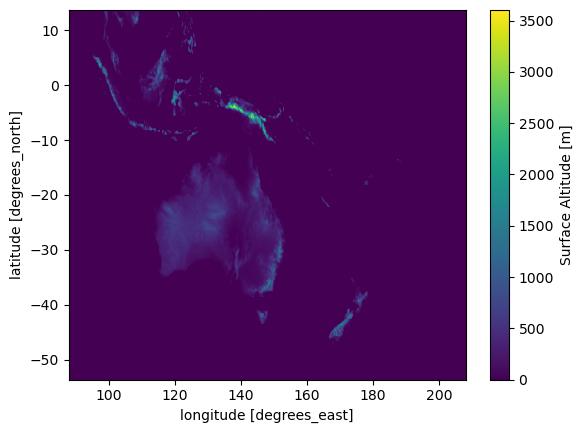

In [11]:
ds["orog"].plot()